Percentage of pre-annotated features versus feature quantile by peak area (1%-99% with stepwise as 1%) from 45 Orbitrap studies, for positive and negative ionization datasets respectively.

In [1]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
sys.path.insert(0, '../..')
from mining import * 
from isf_helper import explain_a_dataset_by_mz_deltas


In [2]:
# Input data 

orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]
pos_orbi_datasets = [x for x in orbi_datasets if 'pos' in x]
neg_orbi_datasets = [x for x in orbi_datasets if 'neg' in x]

dict_rtwindow = {}
for line in open('elution_parameters_45studies_orbi.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

In [4]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'CH3OH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'ACN*2'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'CH3OH'),
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''14.0155	900	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
18.0104	885	18.010565	water	{'H': 2, 'O': 1}
2.0155	717	2.01565	± 2H, opening or forming of double bond	{'H': 2}
44.0261	652	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
28.0312	621	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
15.9948	479	15.9949	oxidation	{'O': 1}
17.0264	451	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
26.0155	440	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
27.9947	433	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
42.0104	340	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	{'C': 2, 'H': 2, 'O': 1}
67.9872	325	67.987424	NaCOOH	{'C': 1, 'O': 2, 'Na': 1, 'H': 1}
13.9791	321	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
23.9998	317	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
16.0312	314	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
42.0468	314	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
46.0053	313	46.005305	addition of Phosphate and dechlorination. Reaction: (+HPO3) and (-Cl+H)	{'H': 2, 'O': 3, 'P': 1, 'Cl': -1}
88.0522	304	88.052429	butanoic acid	{'C': 4, 'H': 8, 'O': 2}
41.0263	295	41.026549	Acetonitrile	{'C': 2, 'H': 3, 'N': 1}
22.9852	281	22.989218	 Na  	{ 'Na':1 }
30.0468	267	30.04695	addition of C2H4 and hydrogenation. Reaction: (+C2H4) and (+H2)	{'C': 2, 'H': 6}
35.037	157	35.037114	addition of water and addition of ammonia. Reaction: (+H2O) and (+NH3)	{'H': 5, 'N': 1, 'O': 1}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [5]:
def assign_intensity_quartile(list_features):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1, x2, x3 = np.quantile(intensities, 0.75
                        ), np.quantile(intensities, 0.5
                         ), np.quantile(intensities, 0.25)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # 1st quartile
        elif x1 >= f['peak_area'] > x2:
            d[f['id']] = 2
        elif x2 >= f['peak_area'] > x3:
            d[f['id']] = 3
        else:
            d[f['id']] = 4
    return d

In [6]:
def assign_intensity_in_or_out_by_percent(list_features, percent):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1 = np.quantile(intensities, percent)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # top 10%
        else:
            d[f['id']] = 2
    return d

In [10]:


# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
quartile_matches_pos = {}
top_matches_pos = {}
for study in tqdm.tqdm(pos_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'pos'
        top_matches_pos[study] = {}
        _n, list_features = read_features_from_asari_table(
            open(f'../../../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_pos, 
                                adduct_search_patterns=adduct_search_patterns_pos,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
    
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, pos_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )

        # dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        # quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]
        
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        # top features with different percentage
        top_matches = {}
        for percent in range(1, 100):
            dict_intensity_top_or_not = assign_intensity_in_or_out_by_percent(list_features, percent=percent/100)
            top_matches[percent] = [dict_intensity_top_or_not[x] for x in preannotated_feature_ids]

            top_matches_pos[study][percent] = {
                'M0': [dict_intensity_top_or_not[x] for x in M0_ids],
                'isotope': [dict_intensity_top_or_not[x] for x in isotope_ids],
                'fragment': [dict_intensity_top_or_not[x] for x in fragment_ids],
                'singletons': [dict_intensity_top_or_not[x] for x in singleton_ids],
            }

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                # 'quartile_matches': quartile_matches,
                'top_matches': top_matches,
            }
        tally_pos.append(cur_tally)
        
        round_id = '01312025_1'
        os.makedirs(f'output/{round_id}/pos/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{round_id}/pos/{study}/ecpds.json', 'w'))
        # json.dump(cur_tally, open(f'output/{round_id}/pos/{study}/tally.json', 'w'))
        # json.dump(quartile_matches_pos[study], open(f'output/{round_id}/pos/{study}/quartile_matches.json', 'w'))
        json.dump(top_matches_pos[study], open(f'output/{round_id}/pos/{study}/top_10_matches.json', 'w'))

100%|██████████| 22/22 [50:25<00:00, 137.50s/it] 


### Scan from 1% to 99% quantile

In [19]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 
# fig3a
# preannotated_features = [len(x['quartile_matches']) for x in tally_pos]
# unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

#fig3b
top_percs_pos = {}
top_percs_pos_all_preannotated = {}
for percent in range(1, 100):
    top_percs_pos_all_preannotated[percent] = [[], []]
    top_percs_pos[percent] = {'M0': [[], []], 
                            'isotope': [[], []], 
                            'fragment': [[], []], 
                            'singletons': [[], []], }
for x in tally_pos:

    for percent, match_detail in top_matches_pos[x['study']].items():
        # if percent == 1:
        list_q = x['top_matches'][percent]
        # print(len(list_q))
        part_sizes = x['num_features'] * (100 - percent) / 100, x['num_features'] * percent / 100  # will be 2 parts: 10% and remaining 90%

        for type, q in match_detail.items():
            for ii in range(2):
                top_percs_pos[percent][type][ii].append(100 * len([y for y in q if y==ii+1]) / part_sizes[ii])
                # Use all preannotated features for violin plot
        
        for ii in range(2):
            # print(100 * len([y for y in list_q if y==ii+1]) / part_sizes[ii])
            # print((len([y for y in list_q if y==ii+1]), x['num_features']))
            top_percs_pos_all_preannotated[percent][ii].append(100 * len([y for y in list_q if y==ii+1]) / part_sizes[ii])

# median_perc_pos = {}
# for type, qpp in top_percs_pos.items():
#     median_perc_pos[type] = [np.mean(qpp[ii]) for ii in range(2)]
# median_perc_pos

In [20]:
# np.mean(top_percs_pos_all_preannotated[0])
arr = []
for percent, detail in top_percs_pos_all_preannotated.items():
    arr.append(np.mean(detail[0]))

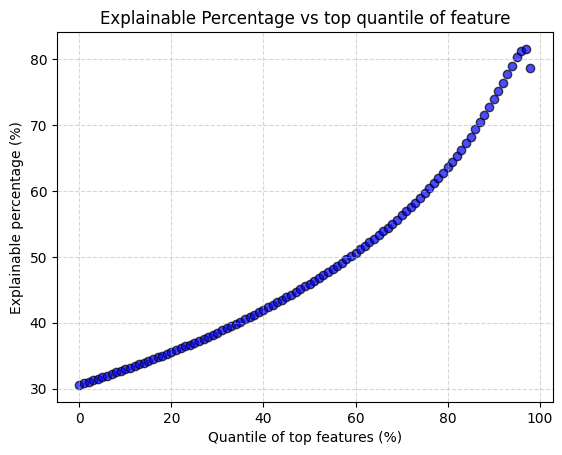

In [ ]:
indices = np.arange(len(arr))  # Create indices for the x-axis

# Scatter plot
plt.scatter(indices, arr, color='blue', alpha=0.7, edgecolor='black')
plt.title('Explainable Percentage vs top quantile of feature')
plt.xlabel('Quantile of top features (%)')
plt.ylabel('Explainable percentage (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('5c_1_explainable_perc_vs_top_quantile_pos.pdf')

## Do neg ion studies

In [14]:
neg_candidate_fragments = '''67.9874	819	67.987424	NaCOOH	{'C': 1, 'O': 2, 'Na': 1, 'H': 1}
14.0156	693	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
2.0155	570	2.01565	"± 2H, opening or forming of double bond"	{'H': 2}
82.0029	431	82.005479	succinylation and loss of water. Reaction: (+C4H4O3) and (-H2O)	{'C': 4, 'H': 2, 'O': 2}
15.9948	415	15.9949	oxidation	{'O': 1}
43.9898	394	43.9898	addition of CO2. Reaction: (+CO2)	{'C': 1, 'O': 2}
18.0105	374	18.010565	water	{'H': 2, 'O': 1}
11.9999	359	12	methylation and reduction	{'C': 1}
30.0105	352	30.010564	addition of acetic acid and loss of CO. Reaction: (+C2H2O2) and (-CO)	{'C': 1, 'H': 2, 'O': 1}
26.0156	346	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
46.0054	339	46.005479	formic acid adduct	{'C': 1, 'H': 2, 'O': 2}
28.0312	327	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
44.0261	303	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
27.9949	297	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
23.9999	265	24	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
13.9792	256	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
42.0105	250	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	{'C': 2, 'H': 2, 'O': 1}
16.0312	239	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
60.021	229	60.02113	acetylation and addition of water. Reaction: (+C2H2O) and (+H2O)	{'C': 2, 'H': 4, 'O': 2}
135.9748	222	135.974848	2X NaCOOH	{'C': 2, 'O': 4, 'H': 2, 'Na': 2}
'''
neg_candidate_fragments = [
    (float(x.split()[0]), x) for x in neg_candidate_fragments.splitlines()
]

isf_candidate_fragments_neg = [x[0] for x in neg_candidate_fragments]

In [15]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 70 minutes

tally_neg = []
quartile_matches_neg = {}
top_matches_neg = {}
for study in tqdm.tqdm(neg_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'neg'
        top_matches_neg[study] = {}
        _n, list_features = read_features_from_asari_table(
            open(f'../../../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_neg, 
                                adduct_search_patterns=adduct_search_patterns_neg,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
    
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, isf_candidate_fragments_neg, 
            rt_stdev=dict_rtwindow[study]
            )

        # dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        # quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]
        
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        # top features with different percentage
        top_matches = {}
        for percent in range(1, 100):
            dict_intensity_top_or_not = assign_intensity_in_or_out_by_percent(list_features, percent=percent/100)
            top_matches[percent] = [dict_intensity_top_or_not[x] for x in preannotated_feature_ids]

            top_matches_neg[study][percent] = {
                'M0': [dict_intensity_top_or_not[x] for x in M0_ids],
                'isotope': [dict_intensity_top_or_not[x] for x in isotope_ids],
                'fragment': [dict_intensity_top_or_not[x] for x in fragment_ids],
                'singletons': [dict_intensity_top_or_not[x] for x in singleton_ids],
            }

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                # 'quartile_matches': quartile_matches,
                'top_matches': top_matches,
            }
        tally_neg.append(cur_tally)
        
        round_id = '01312025_1'
        os.makedirs(f'output/{round_id}/neg/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{round_id}/neg/{study}/ecpds.json', 'w'))
        # json.dump(cur_tally, open(f'output/{round_id}/neg/{study}/tally.json', 'w'))
        # json.dump(quartile_matches_neg[study], open(f'output/{round_id}/neg/{study}/quartile_matches.json', 'w'))
        json.dump(top_matches_neg[study], open(f'output/{round_id}/neg/{study}/top_10_matches.json', 'w'))

100%|██████████| 23/23 [1:08:38<00:00, 179.04s/it]


### Scan from 1% to 99% quantile

In [22]:
top_percs_neg = {}
top_percs_neg_all_preannotated = {}
for percent in range(1, 100):
    top_percs_neg_all_preannotated[percent] = [[], []]
    top_percs_neg[percent] = {'M0': [[], []], 
                            'isotope': [[], []], 
                            'fragment': [[], []], 
                            'singletons': [[], []], }
for x in tally_neg:

    for percent, match_detail in top_matches_neg[x['study']].items():
        # if percent == 1:
        list_q = x['top_matches'][percent]
        # print(len(list_q))
        part_sizes = x['num_features'] * (100 - percent) / 100, x['num_features'] * percent / 100  # will be 2 parts: 10% and remaining 90%

        for type, q in match_detail.items():
            for ii in range(2):
                top_percs_neg[percent][type][ii].append(100 * len([y for y in q if y==ii+1]) / part_sizes[ii])
                # Use all preannotated features for violin plot
        
        for ii in range(2):
            # print(100 * len([y for y in list_q if y==ii+1]) / part_sizes[ii])
            # print((len([y for y in list_q if y==ii+1]), x['num_features']))
            top_percs_neg_all_preannotated[percent][ii].append(100 * len([y for y in list_q if y==ii+1]) / part_sizes[ii])

# median_perc_neg = {}
# for type, qpp in top_percs_neg.items():
#     median_perc_neg[type] = [np.mean(qpp[ii]) for ii in range(2)]
# median_perc_neg

In [23]:
arr = []
for percent, detail in top_percs_neg_all_preannotated.items():
    arr.append(np.mean(detail[0]))

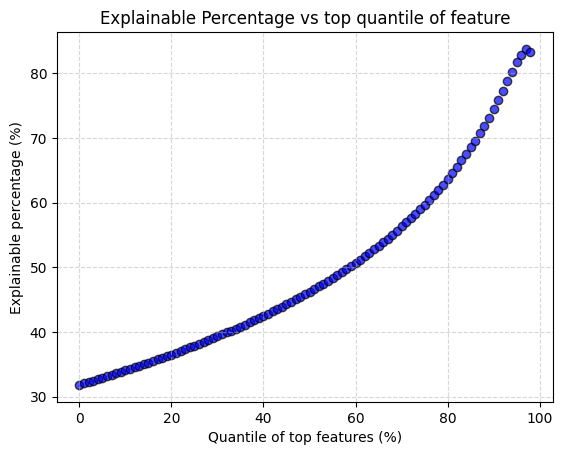

In [ ]:
indices = np.arange(len(arr))  # Create indices for the x-axis

# Scatter plot
plt.scatter(indices, arr, color='blue', alpha=0.7, edgecolor='black')
plt.title('Explainable Percentage vs top quantile of feature')
plt.xlabel('Quantile of top features (%)')
plt.ylabel('Explainable percentage (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('5c_2_explainable_perc_vs_top_quantile_neg.pdf')